In [1]:
import gc
import glob
import os
import time
import traceback
from contextlib import contextmanager
from enum import Enum
from typing import Dict, List, Optional, Tuple
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from joblib import delayed, Parallel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")

def print_trace(name: str = ''):
    print(f'ERROR RAISED IN {name or "anonymous"}')
    print(traceback.format_exc())

DATA_DIR = '/kaggle/input/optiver-realized-volatility-prediction'
# model & ensemble configurations
PREDICT_CNN = True
PREDICT_MLP = True
PREDICT_GBDT = True
PREDICT_TABNET = False

GBDT_NUM_MODELS = 5 #3
GBDT_LR = 0.02  # 0.1

NN_VALID_TH = 0.25
NN_MODEL_TOP_N = 3
TAB_MODEL_TOP_N = 3
ENSEMBLE_METHOD = 'mean'
NN_NUM_MODELS = 10
TABNET_NUM_MODELS = 5

# data configurations
USE_PRECOMPUTE_FEATURES = False  # Load precomputed features for train.csv from private dataset (just for speed up)


# for saving quota
IS_1ST_STAGE = True
SHORTCUT_NN_IN_1ST_STAGE = False  # early-stop training to save GPU quota
SHORTCUT_GBDT_IN_1ST_STAGE = False
MEMORY_TEST_MODE = False

# for ablation studies
CV_SPLIT = 'time'  # 'time': time-series KFold 'group': GroupKFold by stock-id
USE_PRICE_NN_FEATURES = True  # Use nearest neighbor features that rely on tick size
USE_VOL_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_SIZE_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_RANDOM_NN_FEATURES = False  # Use random index to aggregate neighbors

USE_TIME_ID_NN = True  # Use time-id based neighbors
USE_STOCK_ID_NN = True  # Use stock-id based neighbors

ENABLE_RANK_NORMALIZATION = True  # Enable rank-normalization

train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
stock_ids = set(train['stock_id'])


In [2]:
import umap

In [3]:
class DataBlock(Enum):
    TRAIN = 1
    TEST = 2
    BOTH = 3

#This defines a type called DataBlock, which is used to specify whether data belongs to the training set, testing set, or both.
#TRAIN = 1 → Represents training data.
#TEST = 2 → Represents testing data.
#BOTH = 3 → Represents both training and testing data

def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    return pd.read_parquet(os.path.join(DATA_DIR, directory, f'stock_id={stock_id}'))
#This function loads stock market data from a file.
#stock_id: The ID of the stock.
#directory: Specifies which dataset (train/test).
#It reads a Parquet file (a type of data file format) containing stock data and returns it as a Pandas DataFrame.

def load_data(stock_id: int, stem: str, block: DataBlock) -> pd.DataFrame:
    if block == DataBlock.TRAIN:
        return load_stock_data(stock_id, f'{stem}_train.parquet')
    elif block == DataBlock.TEST:
        return load_stock_data(stock_id, f'{stem}_test.parquet')
    else:
        return pd.concat([
            load_data(stock_id, stem, DataBlock.TRAIN),
            load_data(stock_id, stem, DataBlock.TEST)
        ]).reset_index(drop=True)

#Loads stock data based on whether it’s training, testing, or both.

def load_book(stock_id: int, block: DataBlock=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'book', block)

#These are wrapper functions to make it easier to load specific types of data:

def load_trade(stock_id: int, block=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'trade', block)


def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap


def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

#These calculate the Weighted Average Price (WAP), a measure of price using both bid and ask prices.

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

#Computes realized volatility, which measures how much the stock price fluctuates.
#It squares each value in the series, sums them up, and takes the square root.

def log_return(series: np.ndarray):
    return np.log(series).diff()


def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)


def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        if c[0] in ['time_id', 'stock_id']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret

#Formats column names to include a prefix like book_ or trade_.


def make_book_feature(stock_id, block=DataBlock.TRAIN):
    book = load_book(stock_id, block)

    
    book['wap1'] = calc_wap1(book)
    book['wap2'] = calc_wap2(book)

    
    book['log_return1'] = book.groupby(['time_id'])['wap1'].transform(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].transform(log_return)
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].transform(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].transform(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].transform(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].transform(log_return)

    # The rest of the code remains unchanged
    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))

    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread': [np.sum, np.mean, np.std],
        'bid_spread': [np.sum, np.mean, np.std],
        'ask_spread': [np.sum, np.mean, np.std],
        'total_volume': [np.sum, np.mean, np.std],
        'volume_imbalance': [np.sum, np.mean, np.std]
    }

    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = flatten_name('book', agg.columns)
    agg['stock_id'] = stock_id

    #Aggregates the data per time_id.

    
    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'book_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    #Adds time-based features (last 450, 300, and 150 seconds).
    return agg



def make_trade_feature(stock_id, block=DataBlock.TRAIN):
    trade = load_trade(stock_id, block)
    trade['log_return'] = trade.groupby('time_id')['price'].transform(log_return)

    features = {
        'log_return': [realized_volatility],
        'seconds_in_bucket': ['count'],
        'size': [np.sum],
        'order_count': [np.mean],
    }

    # Aggregating data at the 'time_id' level
    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = flatten_name('trade', agg.columns)
    agg['stock_id'] = stock_id

    # Adding time-based features (450, 300, 150 seconds)
    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'trade_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    
    return agg
#Aggregates features like: Realized volatility, Order size, Number of orders



def make_book_feature_v2(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    prices = book.set_index('time_id')[['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']]
    time_ids = list(set(prices.index))

    ticks = {}
    for tid in time_ids:
        try:
            price_list = prices.loc[tid].values.flatten()
            price_diff = sorted(np.diff(sorted(set(price_list))))
            ticks[tid] = price_diff[0]
        except Exception:
            print_trace(f'tid={tid}')
            ticks[tid] = np.nan
        
    dst = pd.DataFrame()
    dst['time_id'] = np.unique(book['time_id'])
    dst['stock_id'] = stock_id
    dst['tick_size'] = dst['time_id'].map(ticks)

    return dst
#Calculates the tick size (smallest price movement in stock trading).
#Uses np.diff() to find differences between unique price levels.



def make_features(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature)(i, block) for i in stock_ids)
        book = pd.concat(books)

    with timer('trades'):
        trades = Parallel(n_jobs=-1)(delayed(make_trade_feature)(i, block) for i in stock_ids)
        trade = pd.concat(trades)

    with timer('extra features'):
        df = pd.merge(base, book, on=['stock_id', 'time_id'], how='left')
        df = pd.merge(df, trade, on=['stock_id', 'time_id'], how='left')
        #df = make_extra_features(df)

    return df
#Generates all features for multiple stocks in parallel.
#Merges book and trade data.
    

def make_features_v2(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books(v2)'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature_v2)(i, block) for i in stock_ids)
        book_v2 = pd.concat(books)

    d = pd.merge(base, book_v2, on=['stock_id', 'time_id'], how='left')
    return d

#Generates all features for multiple stocks in parallel.
#Merges book and trade data.

In [4]:
if USE_PRECOMPUTE_FEATURES:
    with timer('load feather'):
        df = pd.read_feather('features_v2.f')
else:
    df = make_features(train, DataBlock.TRAIN)
    df = make_features_v2(df, DataBlock.TRAIN)
    df.to_feather('features_v2.f')  # save cache


[books] 1029.291sec
[trades] 156.735sec
[extra features] 1.263sec


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[books(v2)] 437.803sec


In [5]:
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
if len(test) == 3:
    print('is 1st stage')
    IS_1ST_STAGE = True


#This is a memory stress test:
#If 1st stage testing is active and memory testing mode is on, it does NOT use the real test data.
#Instead, it copies the first 170,000 rows from the training data (df.iloc[:170000]) to simulate memory usage.
#Modifies the time_id column to avoid overlap with training data.
#Clears the row_id column (possibly because it's not relevant in this simulation).
#checks RAM usage and performance before actual deployment


if IS_1ST_STAGE and MEMORY_TEST_MODE:
    print('use copy of training data as test data to immitate 2nd stage RAM usage.')
    test_df = df.iloc[:170000].copy()
    test_df['time_id'] += 32767
    test_df['row_id'] = ''
else:
    test_df = make_features(test, DataBlock.TEST)
    test_df = make_features_v2(test_df, DataBlock.TEST)
#make_features(test, DataBlock.TEST): Extracts trading-related features.
#make_features_v2(test_df, DataBlock.TEST): Enhances features with ticks.

print(df.shape) #(rows,columns)
print(test_df.shape) #(rows,columns)
df = pd.concat([df, test_df.drop('row_id', axis=1)]).reset_index(drop=True)

#Merges the test data (test_df) with the training data (df).
#Drops the row_id column before merging ( because it’s not needed).
#Resets the index to maintain a clean sequential order.

is 1st stage
[books] 0.123sec
[trades] 0.042sec
[extra features] 0.005sec
[books(v2)] 0.021sec
(428932, 216)
(3, 216)


In [6]:
%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")
    

def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick
#Derives a price metric based on the smallest increment in price data.

def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df
#Compute a derived price for each time_id for a given stock file



In [7]:
import umap
import pandas as pd
import numpy as np
# import yfinance as yf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from joblib import Parallel, delayed
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [8]:
import glob

%config InlineBackend.figure_format = 'retina'
sns.set_theme('notebook', 'white', font_scale=1.2, palette='tab10')
from sklearn.manifold import TSNE, SpectralEmbedding
with timer('load files'):
        data_dir = 'data'
        df_files = pd.DataFrame(
            {'book_path': glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet/**/*.parquet')}) \
            .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')
        df_target_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
        df_volatility_train = df_target_train.groupby('time_id').target.mean()


with timer('calc prices'):
        df_prices_denorm = pd.concat(Parallel(n_jobs=-1, verbose=0)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices_denorm = df_prices_denorm.pivot(index = 'time_id', columns= 'stock_id',values= 'price')
        df_prices_denorm_scaled = df_prices_denorm.fillna(df_prices_denorm.mean())
        df_prices_denorm_scaled = pd.DataFrame(minmax_scale(df_prices_denorm_scaled), index=df_prices_denorm.index)


    
with timer('Spectral Embeddings'):
        emb = SpectralEmbedding(random_state=2)
        emb_denorm = emb.fit_transform(df_prices_denorm_scaled)
        df_prices_denorm_ordered = df_prices_denorm.iloc[np.argsort(-emb_denorm[:, 0])]
        df_prices_denorm_ordered.reset_index(drop=True).rolling(10).mean(). \
        plot(subplots=True, layout=(-1, 5), figsize=(15, 60), sharex=True, lw=1)
        plt.suptitle('Denormalized prices in recovered time order')
        plt.subplots_adjust(top=0.97, wspace=0.3);


    # AMZN
_, ax = plt.subplots(1, 1, figsize=(15, 5))
df_prices_denorm_ordered[61].rolling(10).mean().to_frame().set_index(np.linspace(0.02, 0.86, len(df_prices_denorm_ordered))).plot(lw=1, ax=ax);
    
timeid_order = pd.DataFrame(df_prices_denorm_ordered.index)


[load files] 0.196sec


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[calc prices] 28.858sec
[Spectral Embeddings] 5.191sec


In [9]:
USE_PRECOMPUTE_FEATURES_1= False

In [10]:
if CV_SPLIT == 'time':
    with timer('calculate order of time-id'):
        if USE_PRECOMPUTE_FEATURES_1:
            # Load precomputed time_id order
            timeid_order = pd.read_csv(os.path.join(DATA_DIR, 'optiver-time-id-ordered', 'time_id_order.csv'))
        else:
            # Use the existing time_id DataFrame
            timeid_order = timeid_order  # Replace `time_id_df` with your actual DataFrame variable name
            timeid_order['time_id_order'] = timeid_order.index  # Add an increasing index as the order
    print(timeid_order) 
    with timer('make folds'):
        # Map time_id_order to df
        df['time_id_order'] = df['time_id'].map(timeid_order.set_index('time_id')['time_id_order'])
        df = df.sort_values(['time_id_order', 'stock_id']).reset_index(drop=True)
        print(df)
        # Define fold boundaries
        folds_border = [3830 - 383*4, 3830 - 383*3, 3830 - 383*2, 3830 - 383*1]
        time_id_orders = df['time_id_order']

        # Create folds
        folds = []
        for i, border in enumerate(folds_border):
            idx_train = np.where(time_id_orders < border)[0]
            idx_valid = np.where((border <= time_id_orders) & (time_id_orders < border + 383))[0]
            folds.append((idx_train, idx_valid))

            print(f"folds{i}: train={len(idx_train)}, valid={len(idx_valid)}")

    # Clean up
    del df['time_id_order']

elif CV_SPLIT == 'group':
    # Use GroupKFold for cross-validation
    gkf = GroupKFold(n_splits=4)
    folds = []

    for i, (idx_train, idx_valid) in enumerate(gkf.split(df, None, groups=df['time_id'])):
        folds.append((idx_train, idx_valid))
else:
    raise ValueError("Invalid CV_SPLIT value. Use 'time' or 'group'.")

# Reset indices for df and df_test
df.reset_index(drop=True, inplace=True)
print(df)


[calculate order of time-id] 0.001sec
      time_id  time_id_order
0        7854              0
1       22487              1
2       20351              2
3       13421              3
4       13473              4
...       ...            ...
3825    12182           3825
3826     2867           3826
3827    18077           3827
3828    32704           3828
3829    27524           3829

[3830 rows x 2 columns]
        stock_id  time_id    target  book.seconds_in_bucket.count  \
0              0     7854  0.001480                         287.0   
1              1     7854  0.001215                         191.0   
2              2     7854  0.001234                         280.0   
3              3     7854  0.002602                         216.0   
4              4     7854  0.001994                         138.0   
...          ...      ...       ...                           ...   
428930       125    27524  0.001462                         487.0   
428931       126    27524  0.004248  

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value enc

In [11]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from typing import Optional, Dict

N_NEIGHBORS_MAX = 80

class Neighbors:
    def __init__(self, 
                 name: str, 
                 pivot: pd.DataFrame,        
                 p: float,                   
                 metric: str = 'minkowski',  
                 metric_params: Optional[Dict] = None, 
                 exclude_self: bool = False):

        self.name = name
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric

        if metric == 'random':
            n_queries = len(pivot)
            self.neighbors = np.random.randint(n_queries, size=(n_queries, N_NEIGHBORS_MAX))
        else:
            nn = NearestNeighbors(
                n_neighbors=N_NEIGHBORS_MAX, 
                p=p, 
                metric=metric, 
                metric_params=metric_params
            )
            nn.fit(pivot)
            _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None  

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        raise NotImplementedError()

    def make_nn_feature(self, n=5, agg=np.mean) -> pd.DataFrame:                                     
        assert self.feature_values is not None, "should call rearrange_feature_values beforehand"

        start = 1 if self.exclude_self else 0
        pivot_aggs = np.nanmean(self.feature_values[start:n, :, :], axis=0) 

        pivot_aggs = np.nan_to_num(pivot_aggs, nan=np.nanmean(pivot_aggs))

        pivot_aggs = pd.DataFrame(
            pivot_aggs, 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.unstack().reset_index()
        dst.columns = ['stock_id', 'time_id', f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}']
        return dst

class TimeIdNeighbors(Neighbors): 
    """Finds nearest neighbors in time while ensuring causality (including itself)."""

    def get_causal_neighbors(self):
        """Ensures nearest neighbors only use past observations, including itself."""
        n_samples = len(self.pivot)
        self.neighbors = np.full((n_samples, N_NEIGHBORS_MAX), fill_value=-1, dtype=int)  # Initialize

        for i in range(n_samples):
            # Include self in the search space
            past_data = self.pivot.iloc[:i]  # Includes all rows up to index i (including itself)
            
            nn = NearestNeighbors(n_neighbors=min(N_NEIGHBORS_MAX, len(past_data)), p=self.p, metric=self.metric)
            nn.fit(past_data)  # Fit on past data (including self)
            
            _, indices = nn.kneighbors(self.pivot.iloc[[i]], return_distance=True)
            self.neighbors[i, :len(indices[0])] = indices[0]  # Store neighbors

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot(index='time_id', columns='stock_id', values=feature_col)
        feature_pivot.fillna(feature_pivot.mean(), inplace=True)

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))
        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[self.neighbors[:, i], :]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot(index='time_id', columns='stock_id', values=feature_col)
        feature_pivot.fillna(feature_pivot.mean(), inplace=True)

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))
        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[self.neighbors[:, i], :]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col


class StockIdNeighbors(Neighbors):                     
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot(index='time_id', columns='stock_id', values=feature_col)

        # Step 1: Row-wise filling using row means
        feature_pivot = feature_pivot.apply(lambda row: row.fillna(row.mean()), axis=1)

        # Step 2: Column-wise filling using column means
        feature_pivot.fillna(feature_pivot.mean(), inplace=True)

        # Step 3: Final safety fill for any remaining NaNs
        feature_pivot.fillna(0, inplace=True)
        if feature_pivot.isnull().sum().sum() > 0:
            print(f"⚠ ERROR: NaNs remain in feature_pivot even after filling! Count: {feature_pivot.isnull().sum().sum()}")
            print(f"[DEBUG] Feature Pivot Table Sample with NaNs:\n{feature_pivot.head(10)}")
            raise ValueError("Feature pivot table still contains NaNs after filling. Investigate missing stock_id/time_id combinations.")
        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] = feature_pivot.values[:, self.neighbors[:, i]]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col


# Helper to calculate inverse covariance matrix for Mahalanobis distance
def compute_inverse_covariance(pivot: pd.DataFrame) -> np.ndarray:
    """Computes the inverse covariance matrix for Mahalanobis distance."""
    cov_matrix = np.cov(pivot.values.T)  # Compute covariance matrix
    return np.linalg.inv(cov_matrix)  # Inverse of the covariance matrix



In [12]:
# the tau itself is meaningless for GBDT, but useful as input to aggregate in Nearest Neighbor features
df['trade.tau'] = np.sqrt(1 / df['trade.seconds_in_bucket.count'])
df['trade_150.tau'] = np.sqrt(1 / df['trade_150.seconds_in_bucket.count'])
df['book.tau'] = np.sqrt(1 / df['book.seconds_in_bucket.count'])

#These lines transform the "seconds_in_bucket.count" columns using:
#"seconds_in_bucket.count" represents the number of trades recorded within a given time bucket.
#The transformation creates a feature (tau) that scales inversely with the number of trades.

#Why use this formula?
#Higher trade counts → Lower tau

#If a time bucket has many trades, tau will be small. This means high trading activity leads to a smaller feature value.
#Fewer trades → Higher tau

#If a time bucket has fewer trades, tau will be larger.This suggests that less frequent trading might indicate illiquidity or high volatility.
#KNN-based features depend on such transformations.

df['real_price'] = 0.01 / df['tick_size']

#tick_size represents the minimum price movement (e.g., smallest allowed price change in the stock). This formula computes a normalized price feature.
# Why use this formula?
#Higher tick size → Lower real_price

#If a stock has a large tick_size (e.g., minimum price move is $0.05 instead of $0.01), then real_price will be smaller. 
#This suggests that the stock is less liquid or has larger price jumps.
#Lower tick size → Higher real_price

#If tick_size is very small (e.g., $0.0001), then real_price will be larger.
#This indicates a highly liquid stock with fine-grained price movements.



/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
time_id_neighbors: List[Neighbors] = []
stock_id_neighbors: List[Neighbors] = []

with timer('knn fit'):
    df_pv = df[['stock_id', 'time_id']].copy()
    df_pv['price'] = 0.01 / df['tick_size']
    df_pv['vol'] = df['book.log_return1.realized_volatility']
    df_pv['trade.tau'] = df['trade.tau']
    df_pv['trade.size.sum'] = df['book.total_volume.sum']
#This creates a Feature Pivot Table (df_pv) that selects key features.   
    
    if USE_PRICE_NN_FEATURES:  # Use nearest neighbor features that rely on tick size
        pivot = df_pv.pivot(index='time_id', columns='stock_id', values= 'price')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_c', 
                pivot, 
                p=2, 
                metric='canberra', 
                exclude_self=True
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_m', 
                pivot, 
                p=2, 
                metric='mahalanobis',
                metric_params={'VI':np.cov(pivot.values.T)}
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_price_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True)
        )

    #Pivot table: Converts df_pv into a matrix where:
    #Rows → time_id
    #Columns → stock_id
    #Values → price
    
    #Min-Max Scaling: Normalizes prices for proper distance calculations.
    
    #Different Distance Metrics:
    #Canberra Distance (canberra): Sensitive to small differences.
    #Mahalanobis Distance (mahalanobis): Accounts for covariance structure.
    #L1 Distance (p=1): Manhattan distance for stock-based neighbors.
    
    if USE_VOL_NN_FEATURES:  # Use nearest neighbor features that can be calculated without tick size
        pivot = df_pv.pivot(index='time_id', columns='stock_id', values= 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors('time_vol_l1', pivot, p=1)
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_vol_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True
            )
        )
#Same logic as price-based features but using realized volatility.
#Uses L1 distance (Manhattan distance) for neighbor search.


    if USE_SIZE_NN_FEATURES:  # Use nearest neighbor features that can be calculated without tick size
        pivot = df_pv.pivot(index='time_id',columns= 'stock_id', values='trade.size.sum')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_m', 
                pivot, 
                p=2, 
                metric='mahalanobis', 
                metric_params={'VI':np.cov(pivot.values.T)}
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_c', 
                pivot, 
                p=2, 
                metric='canberra'
            )
        )

#Uses total trade size (sum of book order volumes).
#Uses Mahalanobis and Canberra distances.

        
    if USE_RANDOM_NN_FEATURES:  # Use random index to aggregate neighbors
        pivot = df_pv.pivot(index='time_id', columns= 'stock_id',values= 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_random', 
                pivot, 
                p=2, 
                metric='random'
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_random', 
                pivot.transpose(), 
                p=2,
                metric='random')
        )
#Randomly selects neighbors instead of using distance metrics

if not USE_TIME_ID_NN:      # Disable time-based neighbors if flag is False
    time_id_neighbors = []
    
if not USE_STOCK_ID_NN:    # Disable stock-based neighbors if flag is False
    stock_id_neighbors = []

[knn fit] 177.863sec


In [14]:
import pandas as pd
import seaborn as sns
import numpy as np

def calculate_rank_correlation(neighbors, top_n=5):
    # Check if there are neighbors to process
    if not neighbors:
        return
    
    # Create an empty DataFrame to store the neighbor indices
    neighbor_indices = pd.DataFrame()
    
    # Iterate over each neighbor object and collect its indices for the top_n neighbors
    for n in neighbors:
        # Get the top N neighbors and flatten it
        # The idea is to flatten the list of neighbor indices for each 'n'
        neighbor_indices[n.name] = n.neighbors[:, :top_n].flatten()
    
    # Compute the Kendall rank correlation
    correlation_matrix = neighbor_indices.corr(method='kendall')
    
    # Plot the heatmap of Kendall correlation
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

#Computes the Kendall rank correlation between different neighbor methods.
#Kendall correlation measures the similarity in rankings between two datasets.
#Why Kendall?
#It is good for ordinal data (like ranks).
#Less sensitive to outliers than Pearson/Spearman.

In [15]:
time_ids = np.array(sorted(df['time_id'].unique()))
for neighbor in time_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).iloc[1:6]
    )

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10
time_id                                                                       
5            5  30183  31471  26708   7864  22752  10619  11453   1205    9352
11          11   2811  29583  30798  17639  25131  23202  14857   4739    3399
16          16   5829   4275   7783   4487   7845  25439  17530  18634   19747
31          31   6367  19386   1255  12559  19472  18358  31719   6481   26475
32          32     34      4  31554  24443   5916  19164  20430    659   31077

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10
time_id                                                                       
5            5  31471  11453  30183   7864  26708   4091  30430  22752    9889
11          11   2811  29583  30798  14857   4739  17639  25131  23202   13745
16          16   4275  18634   5829  25439  17530   7783   4034   4487   19747
31          31  12559  17429  26475  31719  18358   6481   7897  12348    9456
32          32     34      4   5916  31554  19164   6213    659  25636   24443

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10
time_id                                                                       
5            5   9352  15276  13791   1205  12923  26708   2331   2136   10672
11          11  23202  30798  17639   7460  29583  11227   2811  25131   32597
16          16   9060  25179  25439  21777  15727  17530   6476    211   30791
31          31  10291  15689  18848  22824  14449   1142   6367  21148   25731
32          32     34      4  25584  26883   5235   2772  26430   2502   22014

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10
time_id                                                                       
5            5  30183  23490  22752  26708  20928  13791   1350  31883   10619
11          11  29583  19417   9822  23656   4367  22828  30798  11682   10745
16          16  25439   6121   8168  31443   7845  14721   1040  20630   11497
31          31  13594  16802  20099  31719   1239  19472   3846  12559   13989
32          32     34      4  22014   6482  27822   1392   9215  24921   30803

top_1  top_2  top_3  top_4  top_5  top_6  top_7  top_8  top_9  top_10
time_id                                                                       
5            5  26708  30183  22752   1205  10619   9352  15276  30620    2683
11          11   2811  17639  29583  25131  28020  17604   9822   4739   30798
16          16   5829   4487   6121   7783   1040  29026   7845  17530   16118
31          31   6367  12559  22519  18358   7897  19472  31522  19386   31719
32          34     32      4  15989  11985   3732  26430   3607  10523    4487

In [16]:
stock_ids = np.array(sorted(df['stock_id'].unique()))
for neighbor in stock_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            stock_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(stock_ids, name='stock_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).loc[64]
    )
#Extracts unique stock_ids and sorts them in ascending order.
#Iterates over each StockIdNeighbors object.
#Prints details of each neighbor model.
#Creates a DataFrame to map each stock_id to its top 10 nearest neighbors.
#Displays the row corresponding to stock_id 64, showing its top 10 nearest neighbors.

top_1      64
top_2      53
top_3      56
top_4     124
top_5      73
top_6      96
top_7      30
top_8      28
top_9      66
top_10     33
Name: 64, dtype: int64

top_1      64
top_2      20
top_3      93
top_4      67
top_5      52
top_6     107
top_7      70
top_8     120
top_9     102
top_10     39
Name: 64, dtype: int64

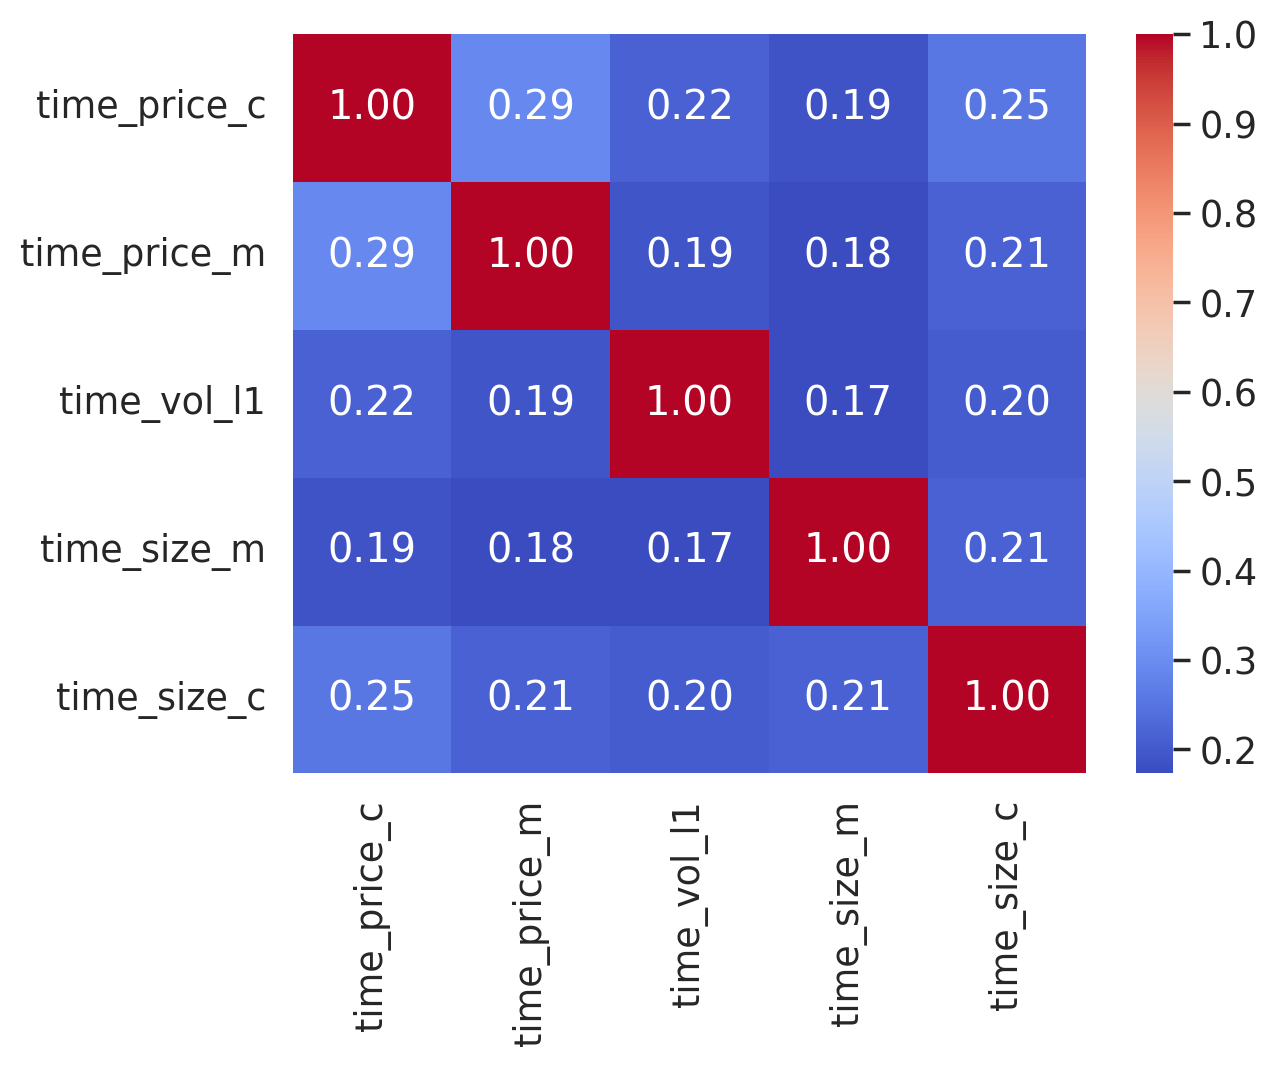

In [17]:
calculate_rank_correlation(time_id_neighbors)

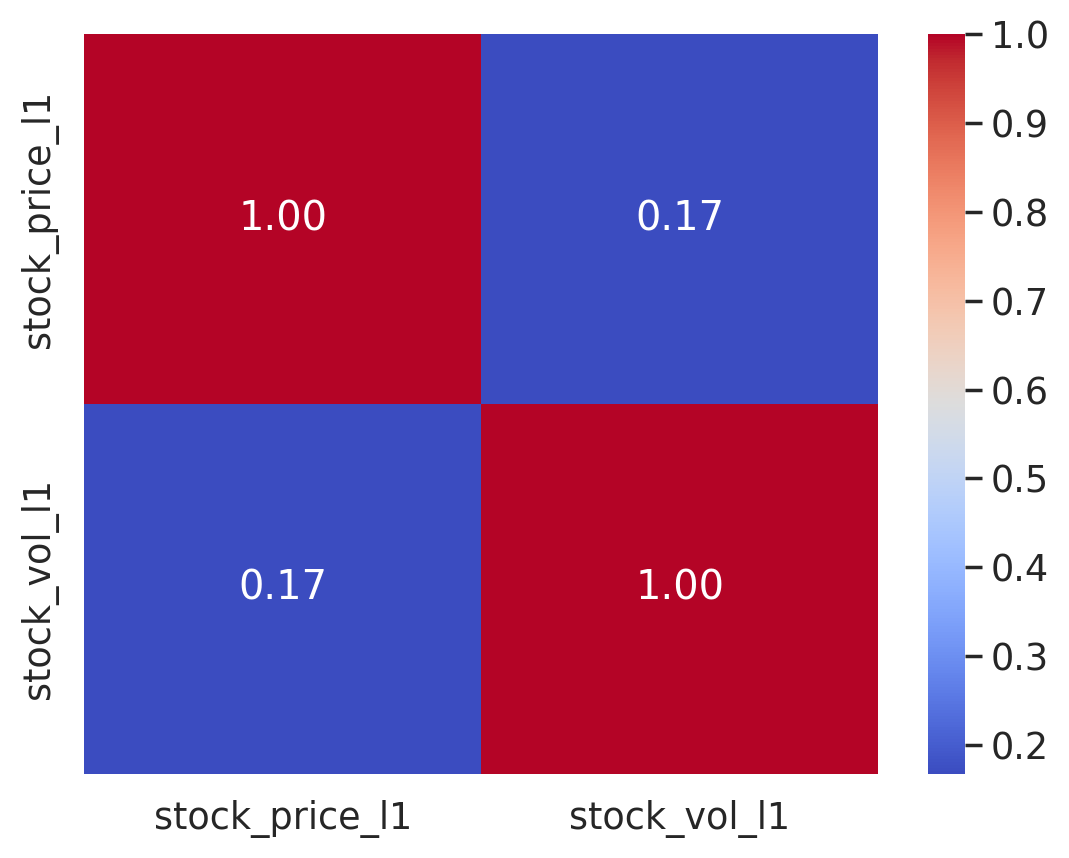

In [18]:
calculate_rank_correlation(stock_id_neighbors)

In [19]:
if ENABLE_RANK_NORMALIZATION:
    df['trade.order_count.mean'] = df.groupby('time_id')['trade.order_count.mean'].rank()
    df['book.total_volume.sum']  = df.groupby('time_id')['book.total_volume.sum'].rank()
    df['book.total_volume.mean'] = df.groupby('time_id')['book.total_volume.mean'].rank()
    df['book.total_volume.std']  = df.groupby('time_id')['book.total_volume.std'].rank()

    df['trade.tau'] = df.groupby('time_id')['trade.tau'].rank()

    for dt in [150, 300, 450]:
        df[f'book_{dt}.total_volume.sum']  = df.groupby('time_id')[f'book_{dt}.total_volume.sum'].rank()
        df[f'book_{dt}.total_volume.mean'] = df.groupby('time_id')[f'book_{dt}.total_volume.mean'].rank()
        df[f'book_{dt}.total_volume.std']  = df.groupby('time_id')[f'book_{dt}.total_volume.std'].rank()
        df[f'trade_{dt}.order_count.mean'] = df.groupby('time_id')[f'trade_{dt}.order_count.mean'].rank()

In [20]:
import gc
import pandas as pd
import numpy as np


#Takes: A pandas DataFrame (df) with stock and market data.
#Returns: A modified DataFrame (df2) with additional nearest neighbor-based features.
#Main Goal: Compute statistical aggregations (mean, min, max, std) over neighboring stocks and time points.


def make_nearest_neighbor_feature(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    print(df2.shape)

    feature_cols_stock = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade_150.tau': [np.mean],
        'book.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
    }

    feature_cols = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'real_price': [np.max, np.mean, np.min],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
        'trade_150.tau_nn20_stock_vol_l1_mean': [np.mean],
        'trade.size.sum_nn20_stock_vol_l1_mean': [np.mean],
    }

    time_id_neighbor_sizes = [3, 5, 10, 20, 40]
    time_id_neighbor_sizes_vol = [2, 3, 5, 10, 20, 40]
    stock_id_neighbor_sizes = [10, 20, 40]

    ndf = None
    feature_list = []

    # Neighbor stock_id
    for feature_col in feature_cols_stock.keys():
        try:
            if feature_col not in df2.columns:
                print(f"Column {feature_col} is skipped")
                continue

            if not stock_id_neighbors:
                continue

            for nn in stock_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            for agg in feature_cols_stock[feature_col]:
                for n in stock_id_neighbor_sizes:
                    try:
                        for nn in stock_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            feature_list.append(dst)
                    except Exception:
                        print_trace('stock-id nn')
                        pass
        except Exception:
            print_trace('stock-id nn')
            pass

    # Merge stock_id neighbor features
    if feature_list:
        ndf = pd.concat(feature_list, axis=1)
        ndf = ndf.loc[:, ~ndf.columns.duplicated()]  # Remove duplicate columns
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left', validate="one_to_one")
    feature_list.clear()
    ndf = None

    print(df2.shape)

    # Neighbor time_id
    for feature_col in feature_cols.keys():
        try:
            if not USE_PRICE_NN_FEATURES and feature_col =='real_price':
                continue
            if feature_col not in df2.columns:
                print(f"Column {feature_col} is skipped")
                continue

            for nn in time_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            time_id_ns = time_id_neighbor_sizes_vol if 'volatility' in feature_col else time_id_neighbor_sizes

            for agg in feature_cols[feature_col]:
                for n in time_id_ns:
                    try:
                        for nn in time_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            feature_list.append(dst)
                    except Exception:
                        print_trace('time-id nn')
                        pass
        except Exception:
            print_trace('time-id nn')

    # Merge time_id neighbor features
    if feature_list:
        ndf = pd.concat(feature_list, axis=1)
        ndf = ndf.loc[:, ~ndf.columns.duplicated()]  # Remove duplicate columns
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left', validate="one_to_one")
    feature_list.clear()
    ndf = None

    # Additional derived features
    try:
        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neighbor_sizes:
                denominator = f"real_price_nn{sz}_time_price_c"
                if f"{denominator}_min" in df2.columns:
                    df2[f'real_price_rankmin_{sz}'] = df2['real_price'] / df2[f"{denominator}_min"]
                else:
                    print(f"Missing column: {denominator}_min")
                if f"{denominator}_max" in df2.columns:
                    df2[f'real_price_rankmax_{sz}'] = df2['real_price'] / df2[f"{denominator}_max"]
                else:
                    print(f"Missing column: {denominator}_max")
                if f"{denominator}_mean" in df2.columns:
                    df2[f'real_price_rankmean_{sz}'] = df2['real_price'] / df2[f"{denominator}_mean"]
                else:
                    print(f"Missing column: {denominator}_mean")
            for sz in time_id_neighbor_sizes_vol:
                denominator = f"book.log_return1.realized_volatility_nn{sz}_time_price_c"
                if f"{denominator}_min" in df2.columns:
                    df2[f'vol_rankmin_{sz}'] = df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_min"]
                else:
                    print(f"Missing column: {denominator}_min")
                if f"{denominator}_max" in df2.columns:
                    df2[f'vol_rankmax_{sz}'] = df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_max"]
                else:
                    print(f"Missing column: {denominator}_max")

    

        # Remove unnecessary price columns
        price_cols = [c for c in df2.columns if 'real_price' in c and 'rank' not in c]
        df2.drop(columns=price_cols, inplace=True, errors='ignore')

        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neighbor_sizes_vol:
                tgt = f'book.log_return1.realized_volatility_nn{sz}_time_price_m_mean'
                if tgt in df2.columns:
                    df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
    except Exception:
        print_trace('nn features')

    return df2



In [21]:
gc.collect()

with timer('make nearest neighbor feature'):
    df2 = make_nearest_neighbor_feature(df)

print(df2.shape)
df2.reset_index(drop=True).to_feather('optiver_df2.f')
print(df2)
gc.collect()


(428935, 220)
(428935, 280)
[make nearest neighbor feature] 520.771sec
(428935, 582)
        stock_id  time_id    target  book.seconds_in_bucket.count  \
0              0     7854  0.001480                         287.0   
1              1     7854  0.001215                         191.0   
2              2     7854  0.001234                         280.0   
3              3     7854  0.002602                         216.0   
4              4     7854  0.001994                         138.0   
...          ...      ...       ...                           ...   
428930       125    27524  0.001462                         487.0   
428931       126    27524  0.004248                         228.0   
428932         0        4       NaN                           3.0   
428933         0       32       NaN                           NaN   
428934         0       34       NaN                           NaN   

        book.wap1.sum  book.wap1.mean  book.wap1.std  book.wap2.sum  \
0          287.

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


0

In [22]:
# skew correction for NN
cols_to_log = [
    'trade.size.sum',
    'trade_150.size.sum',
    'trade_300.size.sum',
    'trade_450.size.sum',
    'volume_imbalance'
]
#This list contains column name patterns that indicate skewed data.
#These columns represent trade sizes and volume imbalances, which can have a long-tailed distribution (some values much larger than others).
#Applying a log transformation reduces the impact of large outliers.
for c in df2.columns:
    for check in cols_to_log:
        try:
            if check in c:
                df2[c] = np.log(df2[c]+1)
                break
        except Exception:
            print_trace('log1p')
#If any error occurs (e.g., df2[c] contains non-numeric values), it logs the error using print_trace('log1p').


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
#Computes rolling mean features for book.log_return1.realized_volatility, grouped by stock_id, and merges them back into df2
try:
    df2.sort_values(by=['stock_id', 'book.total_volume.sum'], inplace=True)
    df2.reset_index(drop=True, inplace=True)

#Sorts df2 by:
#stock_id (to ensure each stock's data is processed sequentially).
#book.total_volume.sum (ensures rolling calculations are performed in the correct order).
#Resets the index after sorting (drops old index and assigns new sequential indices)

    
    roll_target = 'book.log_return1.realized_volatility'
    roll_features = {}

    #Iterates over two window sizes: 3 and 10. Short and longer term trend.

    for window_size in [3, 10]:
        roll_features[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = (
            df2.groupby('stock_id')[roll_target]
               .transform(lambda x: x.rolling(window_size, center=True, min_periods=1).mean())
        )

    # Use `pd.concat()` to merge new rolling features at once
    df2 = pd.concat([df2, pd.DataFrame(roll_features)], axis=1)

except Exception:
    print_trace('mean RV')




In [24]:
# stock-id embedding (helps little)
try:
    lda_n = 3
    lda = LatentDirichletAllocation(n_components=lda_n, random_state=0)

    stock_id_emb = pd.DataFrame(
        lda.fit_transform(pivot.transpose()), 
        index=df_pv.pivot(index='time_id', columns = 'stock_id', values = 'vol').columns
    )

    for i in range(lda_n):
        df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])
except Exception:
    print_trace('LDA')

#Why Use LDA for Stock Embeddings?
#Reduces dimensionality – Instead of handling thousands of individual stocks, we capture key patterns in a few features.
# Finds hidden relationships – Stocks that behave similarly (e.g., tech stocks) will have similar embeddings.
# Improves ML models – These embeddings can be used as input features for stock price prediction models.



In [25]:
df_train = df2[~df2.target.isnull()].copy()
df_test = df2[df2.target.isnull()].copy()
del df2, df_pv
gc.collect()

54

In [26]:

import lightgbm as lgb

In [27]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False


# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # order by average importance across folds
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # plot top-n
    PLOT_TOP_N = 50
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()


def get_X(df_src):
    cols = [c for c in df_src.columns if c not in ['time_id', 'target', 'tick_size']]
    return df_src[cols]


class EnsembleModel:
    def __init__(self, models: List[lgb.Booster], weights: Optional[List[float]] = None):
        self.models = models
        self.weights = weights

        features = list(self.models[0].feature_name())

        for m in self.models[1:]:
            assert features == list(m.feature_name())
#Checks that all models use the same features.
    def predict(self, x):
        predicted = np.zeros((len(x), len(self.models)))

        for i, m in enumerate(self.models):
            w = self.weights[i] if self.weights is not None else 1
            predicted[:, i] = w * m.predict(x)

        ttl = np.sum(self.weights) if self.weights is not None else len(self.models)
        return np.sum(predicted, axis=1) / ttl

    #Runs predictions for each model and stores them in predicted[:, i].
    #If weights are given, normalizes predictions using np.sum(self.weights). Otherwise, averages predictions across models.
    
    def feature_name(self) -> List[str]:
        return self.models[0].feature_name()



In [28]:
X = get_X(df_train)
y = df_train['target']
X.to_feather('X.f')
df_train[['target']].to_feather('y.f')
X_test = get_X(df_test)
print(X_test.shape)


(3, 584)


In [29]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

# Custom RMSPE loss
def rmspe_loss(y_true, y_pred):
    epsilon = K.epsilon()
    y_true_safe = K.maximum(K.abs(y_true), epsilon)
    percentage_error = K.square((y_true - y_pred) / y_true_safe)
    return K.sqrt(K.mean(percentage_error))

# Custom callback to monitor NaN in loss during training
class DebugCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        if np.isnan(loss) or (val_loss is not None and np.isnan(val_loss)):
            print(f"NaN detected at epoch {epoch}: loss={loss}, val_loss={val_loss}")

# --- Data Preprocessing ---
# Assume X, y, X_test, df_test, and DATA_DIR are already defined.
# Clean X and y if they are pandas objects.
if isinstance(X, (pd.DataFrame, pd.Series)):
    if X.isna().any().any() if isinstance(X, pd.DataFrame) else X.isna().any():
        print("Warning: NaN values detected in X input data. Filling missing values with forward fill.")
    X = X.fillna(method='ffill').values
else:
    X = np.array(X)

if isinstance(y, (pd.DataFrame, pd.Series)):
    if y.isna().any().any() if isinstance(y, pd.DataFrame) else y.isna().any():
        print("Warning: NaN values detected in y input data! Filling missing values with forward fill.")
    y = y.fillna(method='ffill').values
else:
    y = np.array(y)

# Scale features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

print("After scaling, any NaNs in X_scaled?", np.isnan(X_scaled).any())
print("After scaling, any NaNs in y_scaled?", np.isnan(y_scaled).any())

# Reshape for LSTM input: (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# --- Parameters ---
best_params = {
    'lstm_units_1': 69,
    'lstm_units_2': 44,
    'dropout_rate': 0.3020399589467795,
    'learning_rate': 0.00013315950716143908,
    'batch_size': 64
}
RSMPE_THRESHOLD = 0.2   # Threshold for accepting a seed's models

ensemble_val_preds = []
ensemble_val_targets = []

# --- Training per Seed ---
seed_ensemble_predictions = []  # To store test predictions from each seed that meets threshold

n_seeds = 10
for seed_offset in range(n_seeds):
    seed = 42 + seed_offset
    print(f"\n--- Training for seed {seed} ---")
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    fold_val_losses = []
    fold_test_predictions = []  # Collect test predictions per fold for this seed
    
    # Loop over folds
    for fold_num, (train_idx, val_idx) in enumerate(folds, start=1):
        print(f"\nFold {fold_num}/{len(folds)} for seed {seed}")
        X_train, X_val = X_lstm[train_idx], X_lstm[val_idx]
        y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]
        
        # Debug: Check for NaNs in split data
        if np.isnan(X_train).any() or np.isnan(y_train).any():
            print(f"NaNs detected in training data for seed {seed}, fold {fold_num}")
        if np.isnan(X_val).any() or np.isnan(y_val).any():
            print(f"NaNs detected in validation data for seed {seed}, fold {fold_num}")
        
        # Build and compile the model
        model = Sequential([
            tf.keras.layers.Input(shape=(X_lstm.shape[1], X_lstm.shape[2])),
            LSTM(best_params['lstm_units_1'], return_sequences=True),
            Dropout(best_params['dropout_rate']),
            LSTM(best_params['lstm_units_2']),
            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=best_params['learning_rate'], clipvalue=1.0),
                      loss=rmspe_loss)
        
        # Train with DebugCallback and early stopping on the validation fold
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
        )
        debug_cb = DebugCallback()
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=best_params['batch_size'],
            callbacks=[early_stop, debug_cb],
            verbose=1
        )
        
        # Evaluate on the validation fold
        val_loss = model.evaluate(X_val, y_val, verbose=0)
        val_pred = model.predict(X_val).flatten()
        ensemble_val_preds.append(val_pred)
        ensemble_val_targets.append(y_val)
        
        print(f"Seed {seed}, Fold {fold_num} validation loss: {val_loss:.4f}")
        fold_val_losses.append(val_loss)
        
        # Get test set predictions from this fold's model
        X_test_scaled = scaler_X.transform(X_test)
        X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
        test_pred = model.predict(X_test_lstm).flatten()
        fold_test_predictions.append(test_pred)
    
    # Average validation loss for the seed
    avg_val_loss = np.mean(fold_val_losses)
    print(f"Seed {seed} average validation loss: {avg_val_loss:.4f}")
    
    # If average validation loss meets threshold, average the test predictions over folds and add to ensemble
    if avg_val_loss < RSMPE_THRESHOLD and not np.isnan(avg_val_loss):
        seed_pred = np.mean(fold_test_predictions, axis=0)
        print(f"Seed {seed} accepted with avg validation loss {avg_val_loss:.4f}")
        seed_ensemble_predictions.append(seed_pred)
        
    else:
        print(f"Seed {seed} rejected with avg validation loss {avg_val_loss:.4f}")
        # Remove the last N folds (one seed's worth) from validation data
        for _ in range(len(folds)):
            ensemble_val_preds.pop()
            ensemble_val_targets.pop()

# --- Final Ensemble Prediction ---
if len(seed_ensemble_predictions) > 0:
    final_ensemble_pred = np.mean(seed_ensemble_predictions, axis=0)
else:
    raise ValueError("No seed met the validation threshold.")

if np.isnan(final_ensemble_pred).any():
    print("NaNs detected in final averaged predictions.")

final_preds = scaler_y.inverse_transform(final_ensemble_pred.reshape(-1, 1)).flatten()

val_preds_all = np.concatenate(ensemble_val_preds)
val_targets_all = np.concatenate(ensemble_val_targets)

# Inverse transform to original scale
val_preds_all_rescaled = scaler_y.inverse_transform(val_preds_all.reshape(-1, 1)).flatten()
val_targets_all_rescaled = scaler_y.inverse_transform(val_targets_all.reshape(-1, 1)).flatten()

# RMSPE
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + 1e-9))))

# QLIKE
def qlike_from_rv(y_true, y_pred):
    eps = 1e-9
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true / y_pred) - np.log(y_true / y_pred) - 1)

final_rmspe = rmspe(val_targets_all_rescaled, val_preds_all_rescaled)
final_qlike = qlike_from_rv(val_targets_all_rescaled, val_preds_all_rescaled)

print("\n==============================")
print("Final Validation Metrics on Ensemble:")
print(f"Average RMSPE: {final_rmspe:.5f}")
print(f"Average QLIKE: {final_qlike:.5f}")
print("==============================")
# --- Prepare Submission ---
df_pred = pd.DataFrame()
df_pred['row_id'] = df_test['stock_id'].astype(str) + '-' + df_test['time_id'].astype(str)
df_pred['target'] = final_preds

submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
submission = pd.merge(submission[['row_id']], df_pred, on='row_id', how='left')
submission['target'] = submission['target'].fillna(0)
submission.to_csv('submission.csv', index=False)
print(submission.head())



<ipython-input-29-35d44e17a8e3>:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').values
<ipython-input-29-35d44e17a8e3>:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method='ffill').values


After scaling, any NaNs in X_scaled? False
After scaling, any NaNs in y_scaled? False

--- Training for seed 42 ---

Fold 1/4 for seed 42
Epoch 1/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 4.6223 - val_loss: 0.2230
Epoch 2/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 5.3619 - val_loss: 0.2162
Epoch 3/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 3.7110 - val_loss: 0.2110
Epoch 4/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 4.8486 - val_loss: 0.2119
Epoch 5/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 3.0314 - val_loss: 0.2110
Epoch 6/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 2.0728 - val_loss: 0.2137
Epoch 7/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 2.7212 - val_loss: 0.2111
Epoch 8/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 2.1014 - val_loss: 0.2088
Epoch 9/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 3.4419 - val_loss: 0.2114
Epoch 10/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - los

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 2.1182 - val_loss: 0.2153
Epoch 2/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 2.5983 - val_loss: 0.2189
Epoch 3/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 2.4124 - val_loss: 0.2198
Epoch 4/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 2.4364 - val_loss: 0.2183
Epoch 5/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 2.6998 - val_loss: 0.2162
Epoch 6/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 2.0335 - val_loss: 0.2202
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
1341/1341 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Seed 42, Fold 2 validation loss: 0.2138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Fold 3/4 for seed 42


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 8.3583 - val_loss: 0.2181
Epoch 2/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 4.4014 - val_loss: 0.2110
Epoch 3/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 3.5437 - val_loss: 0.2099
Epoch 4/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.4145 - val_loss: 0.2085
Epoch 5/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.1483 - val_loss: 0.2083
Epoch 6/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.4271 - val_loss: 0.2080
Epoch 7/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.6856 - val_loss: 0.2139
Epoch 8/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 1.0670 - val_loss: 0.2088
Epoch 9/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 3.7340 - val_loss: 0.2062
Epoch 10/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.6218 - val_loss: 0.2074
Epoch 11/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 3.8684 - val_loss: 0.2069
Epoch 12/50
5362/53

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 8.1676 - val_loss: 0.1941
Epoch 2/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.9470 - val_loss: 0.1975
Epoch 3/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.5475 - val_loss: 0.1929
Epoch 4/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.3084 - val_loss: 0.1927
Epoch 5/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.1715 - val_loss: 0.1963
Epoch 6/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 4.3083 - val_loss: 0.1924
Epoch 7/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 9.7897 - val_loss: 0.1888
Epoch 8/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 7.6745 - val_loss: 0.1900
Epoch 9/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 4.1599 - val_loss: 0.1887
Epoch 10/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 4.5647 - val_loss: 0.1875
Epoch 11/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 3.7503 - val_loss: 0.1862
Epoch 12/50
6032/60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Fold 1/4 for seed 43
Epoch 1/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 4.8738 - val_loss: 0.2158
Epoch 2/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 3.2557 - val_loss: 0.2118
Epoch 3/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 2.7040 - val_loss: 0.2119
Epoch 4/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 4.3376 - val_loss: 0.2132
Epoch 5/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 4.0054 - val_loss: 0.2154
Epoch 6/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 4.3482 - val_loss: 0.2145
Epoch 7/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 3.8521 - val_loss: 0.2118
Epoch 8/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 3.6841 - val_loss: 0.2128
Epoch 9/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 3.2870 - val_loss: 0.2171
Epoch 10/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 2.6873 - val_loss: 0.2108
Epoch 11/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 3.3904 - val_loss: 0.21

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 10.1891 - val_loss: 0.2164
Epoch 2/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.3885 - val_loss: 0.2103
Epoch 3/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 3.7475 - val_loss: 0.2107
Epoch 4/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 6.6464 - val_loss: 0.2118
Epoch 5/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 4.1359 - val_loss: 0.2102
Epoch 6/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 6.1189 - val_loss: 0.2120
Epoch 7/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 4.5807 - val_loss: 0.2113
Epoch 8/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 5.5114 - val_loss: 0.2104
Epoch 9/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 4.1280 - val_loss: 0.2101
Epoch 10/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 4.9940 - val_loss: 0.2087
Epoch 11/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 6.9374 - val_loss: 0.2064
Epoch 12/50
4692/4

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 32.1129 - val_loss: 0.2156
Epoch 2/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 9.1900 - val_loss: 0.2107
Epoch 3/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 6.9998 - val_loss: 0.2082
Epoch 4/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 7.1989 - val_loss: 0.2072
Epoch 5/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 7.2952 - val_loss: 0.2071
Epoch 6/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 6.1084 - val_loss: 0.2053
Epoch 7/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 10.3983 - val_loss: 0.2055
Epoch 8/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 8.6191 - val_loss: 0.2041
Epoch 9/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 6.3384 - val_loss: 0.2044
Epoch 10/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 6.6627 - val_loss: 0.2054
Epoch 11/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 7.2896 - val_loss: 0.2044
Epoch 12/50
5362/

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 1.4586 - val_loss: 0.1958
Epoch 2/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.3356 - val_loss: 0.1922
Epoch 3/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.9006 - val_loss: 0.1940
Epoch 4/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 1.8946 - val_loss: 0.1936
Epoch 5/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.3458 - val_loss: 0.1970
Epoch 6/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.4085 - val_loss: 0.1920
Epoch 7/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 1.3597 - val_loss: 0.1942
Epoch 8/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 2.1197 - val_loss: 0.1914
Epoch 9/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 1.3545 - val_loss: 0.1904
Epoch 10/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 1.3418 - val_loss: 0.1907
Epoch 11/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 1.3706 - val_loss: 0.1911
Epoch 12/50
6032/60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Fold 1/4 for seed 44
Epoch 1/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 3.3439 - val_loss: 0.2253
Epoch 2/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 3.4506 - val_loss: 0.2138
Epoch 3/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 2.9758 - val_loss: 0.2111
Epoch 4/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 4.1402 - val_loss: 0.2130
Epoch 5/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 2.1194 - val_loss: 0.2091
Epoch 6/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.1252 - val_loss: 0.2081
Epoch 7/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 2.3150 - val_loss: 0.2078
Epoch 8/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 2.3456 - val_loss: 0.2071
Epoch 9/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.8461 - val_loss: 0.2078
Epoch 10/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.8919 - val_loss: 0.2066
Epoch 11/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.9066 - val_loss: 0.20

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 1.1615 - val_loss: 0.2131
Epoch 2/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.7288 - val_loss: 0.2092
Epoch 3/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.9058 - val_loss: 0.2075
Epoch 4/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.7192 - val_loss: 0.2070
Epoch 5/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 2.1699 - val_loss: 0.2079
Epoch 6/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.3993 - val_loss: 0.2064
Epoch 7/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.9025 - val_loss: 0.2109
Epoch 8/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.1045 - val_loss: 0.2070
Epoch 9/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.5644 - val_loss: 0.2059
Epoch 10/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.4247 - val_loss: 0.2050
Epoch 11/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.4933 - val_loss: 0.2082
Epoch 12/50
4692/46

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 3.7335 - val_loss: 0.2138
Epoch 2/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 3.1071 - val_loss: 0.2143
Epoch 3/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 1.8953 - val_loss: 0.2096
Epoch 4/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 1.7093 - val_loss: 0.2081
Epoch 5/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 1.8455 - val_loss: 0.2059
Epoch 6/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 3.0144 - val_loss: 0.2068
Epoch 7/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 1.7814 - val_loss: 0.2051
Epoch 8/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 1.2505 - val_loss: 0.2057
Epoch 9/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 1.5278 - val_loss: 0.2048
Epoch 10/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 1.4477 - val_loss: 0.2047
Epoch 11/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 1.2898 - val_loss: 0.2043
Epoch 12/50
5362/53

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.3932 - val_loss: 0.2045
Epoch 2/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.2830 - val_loss: 0.2049
Epoch 3/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.2686 - val_loss: 0.2083
Epoch 4/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.2685 - val_loss: 0.2047
Epoch 5/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.2661 - val_loss: 0.2089
Epoch 6/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.2635 - val_loss: 0.2012
Epoch 7/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.2871 - val_loss: 0.2023
Epoch 8/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.2582 - val_loss: 0.1955
Epoch 9/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.2567 - val_loss: 0.1993
Epoch 10/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.2471 - val_loss: 0.1933
Epoch 11/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.2591 - val_loss: 0.1893
Epoch 12/50
6032/60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Fold 1/4 for seed 45
Epoch 1/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 3.9282 - val_loss: 0.2281
Epoch 2/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.4230 - val_loss: 0.2223
Epoch 3/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 1.6118 - val_loss: 0.2247
Epoch 4/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.3077 - val_loss: 0.2191
Epoch 5/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.1345 - val_loss: 0.2146
Epoch 6/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 1.2325 - val_loss: 0.2149
Epoch 7/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.6053 - val_loss: 0.2123
Epoch 8/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.9948 - val_loss: 0.2088
Epoch 9/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.7154 - val_loss: 0.2107
Epoch 10/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.2965 - val_loss: 0.2097
Epoch 11/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.0735 - val_loss: 0.20

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 11.5272 - val_loss: 0.2124
Epoch 2/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 7.6423 - val_loss: 0.2114
Epoch 3/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 3.3563 - val_loss: 0.2097
Epoch 4/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.0759 - val_loss: 0.2096
Epoch 5/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 5.3372 - val_loss: 0.2154
Epoch 6/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 4.1979 - val_loss: 0.2095
Epoch 7/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 4.9590 - val_loss: 0.2100
Epoch 8/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 4.9421 - val_loss: 0.2174
Epoch 9/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 4.7993 - val_loss: 0.2082
Epoch 10/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.2359 - val_loss: 0.2091
Epoch 11/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 3.6322 - val_loss: 0.2065
Epoch 12/50
4692/4

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 4.9189 - val_loss: 0.2156
Epoch 2/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 2.1715 - val_loss: 0.2130
Epoch 3/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 3.2766 - val_loss: 0.2139
Epoch 4/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 2.5884 - val_loss: 0.2115
Epoch 5/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.5450 - val_loss: 0.2094
Epoch 6/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 2.7853 - val_loss: 0.2113
Epoch 7/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.9630 - val_loss: 0.2115
Epoch 8/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.1822 - val_loss: 0.2102
Epoch 9/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 2.7424 - val_loss: 0.2079
Epoch 10/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.7619 - val_loss: 0.2087
Epoch 11/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 2.4708 - val_loss: 0.2076
Epoch 12/50
5362/53

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 1.1395 - val_loss: 0.2048
Epoch 2/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 4.7950 - val_loss: 0.1985
Epoch 3/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.4617 - val_loss: 0.1974
Epoch 4/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 4.4634 - val_loss: 0.1980
Epoch 5/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 3.8498 - val_loss: 0.1949
Epoch 6/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 2.1849 - val_loss: 0.1918
Epoch 7/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 3.6950 - val_loss: 0.1910
Epoch 8/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 3.9537 - val_loss: 0.1924
Epoch 9/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 3.2767 - val_loss: 0.1940
Epoch 10/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 6.1509 - val_loss: 0.1916
Epoch 11/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 2.9243 - val_loss: 0.1919
Epoch 12/50
6032/60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Fold 1/4 for seed 46
Epoch 1/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 13.0054 - val_loss: 0.2159
Epoch 2/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 19.9588 - val_loss: 0.2124
Epoch 3/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 11.7060 - val_loss: 0.2112
Epoch 4/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 15.8331 - val_loss: 0.2141
Epoch 5/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 10.2599 - val_loss: 0.2107
Epoch 6/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 7.3904 - val_loss: 0.2111
Epoch 7/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 12.7500 - val_loss: 0.2109
Epoch 8/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 19.6555 - val_loss: 0.2099
Epoch 9/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 8.9244 - val_loss: 0.2083
Epoch 10/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 10.1637 - val_loss: 0.2076
Epoch 11/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 15.4937 - val_l

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.8939 - val_loss: 0.2163
Epoch 2/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.4552 - val_loss: 0.2118
Epoch 3/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.9118 - val_loss: 0.2105
Epoch 4/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.4835 - val_loss: 0.2067
Epoch 5/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.4514 - val_loss: 0.2087
Epoch 6/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.4638 - val_loss: 0.2056
Epoch 7/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.5420 - val_loss: 0.2053
Epoch 8/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.4577 - val_loss: 0.2038
Epoch 9/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.4180 - val_loss: 0.2048
Epoch 10/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.4259 - val_loss: 0.2043
Epoch 11/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 1.0561 - val_loss: 0.2037
Epoch 12/50
4692/46

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 1.2995 - val_loss: 0.2126
Epoch 2/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.9920 - val_loss: 0.2127
Epoch 3/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 1.5500 - val_loss: 0.2116
Epoch 4/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 1.2749 - val_loss: 0.2111
Epoch 5/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 1.3685 - val_loss: 0.2101
Epoch 6/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 1.0270 - val_loss: 0.2123
Epoch 7/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.8286 - val_loss: 0.2095
Epoch 8/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.8634 - val_loss: 0.2109
Epoch 9/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.5712 - val_loss: 0.2095
Epoch 10/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.8296 - val_loss: 0.2069
Epoch 11/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.9716 - val_loss: 0.2081
Epoch 12/50
5362/53

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 10.8436 - val_loss: 0.1983
Epoch 2/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 9.5606 - val_loss: 0.1945
Epoch 3/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 20.2899 - val_loss: 0.1941
Epoch 4/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 11.4843 - val_loss: 0.1949
Epoch 5/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 7.8631 - val_loss: 0.1933
Epoch 6/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 8.1834 - val_loss: 0.1948
Epoch 7/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 4.0030 - val_loss: 0.1935
Epoch 8/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 7.8881 - val_loss: 0.1937
Epoch 9/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 12.7048 - val_loss: 0.1912
Epoch 10/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 13.3552 - val_loss: 0.1883
Epoch 11/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 10.5472 - val_loss: 0.1880
Epoch 12/50
6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Fold 1/4 for seed 47
Epoch 1/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 6.7150 - val_loss: 0.2203
Epoch 2/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 4.8328 - val_loss: 0.2117
Epoch 3/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 2.6480 - val_loss: 0.2096
Epoch 4/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 2.2774 - val_loss: 0.2110
Epoch 5/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 6.2832 - val_loss: 0.2084
Epoch 6/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 4.0009 - val_loss: 0.2065
Epoch 7/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 3.4722 - val_loss: 0.2064
Epoch 8/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 2.8089 - val_loss: 0.2065
Epoch 9/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 3.1762 - val_loss: 0.2054
Epoch 10/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 2.5537 - val_loss: 0.2063
Epoch 11/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 2.7006 - val_loss: 0.20

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.6708 - val_loss: 0.2152
Epoch 2/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 1.0669 - val_loss: 0.2120
Epoch 3/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.6634 - val_loss: 0.2086
Epoch 4/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.9390 - val_loss: 0.2075
Epoch 5/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.8200 - val_loss: 0.2085
Epoch 6/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.7381 - val_loss: 0.2076
Epoch 7/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.6040 - val_loss: 0.2055
Epoch 8/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.6010 - val_loss: 0.2067
Epoch 9/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.6044 - val_loss: 0.2046
Epoch 10/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.6664 - val_loss: 0.2049
Epoch 11/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.6019 - val_loss: 0.2066
Epoch 12/50
4692/46

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 7.2414 - val_loss: 0.2174
Epoch 2/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 3.1084 - val_loss: 0.2159
Epoch 3/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 2.6359 - val_loss: 0.2140
Epoch 4/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 2.7947 - val_loss: 0.2137
Epoch 5/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 2.3242 - val_loss: 0.2090
Epoch 6/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 3.4213 - val_loss: 0.2133
Epoch 7/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 3.4157 - val_loss: 0.2083
Epoch 8/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 4.5002 - val_loss: 0.2075
Epoch 9/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 2.9138 - val_loss: 0.2078
Epoch 10/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 2.7794 - val_loss: 0.2058
Epoch 11/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 3.7868 - val_loss: 0.2058
Epoch 12/50
5362/53

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 4.3391 - val_loss: 0.1962
Epoch 2/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.9282 - val_loss: 0.1925
Epoch 3/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 6.4436 - val_loss: 0.1958
Epoch 4/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 5.9320 - val_loss: 0.1914
Epoch 5/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 4.9039 - val_loss: 0.1907
Epoch 6/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 4.8651 - val_loss: 0.1946
Epoch 7/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 4.3225 - val_loss: 0.1906
Epoch 8/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 4.2603 - val_loss: 0.1887
Epoch 9/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 8.9674 - val_loss: 0.1894
Epoch 10/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 4.4481 - val_loss: 0.1893
Epoch 11/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 4.5516 - val_loss: 0.1887
Epoch 12/50
6032/60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Fold 1/4 for seed 48
Epoch 1/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 1.6264 - val_loss: 0.2282
Epoch 2/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.8034 - val_loss: 0.2291
Epoch 3/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.9841 - val_loss: 0.2190
Epoch 4/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.8375 - val_loss: 0.2103
Epoch 5/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.6870 - val_loss: 0.2078
Epoch 6/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.6673 - val_loss: 0.2131
Epoch 7/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.5570 - val_loss: 0.2130
Epoch 8/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.8885 - val_loss: 0.2118
Epoch 9/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.7262 - val_loss: 0.2081
Epoch 10/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.7119 - val_loss: 0.2067
Epoch 11/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.6755 - val_loss: 0.20

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 1.7133 - val_loss: 0.2151
Epoch 2/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.5988 - val_loss: 0.2130
Epoch 3/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.2940 - val_loss: 0.2138
Epoch 4/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.4335 - val_loss: 0.2081
Epoch 5/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 1.3999 - val_loss: 0.2122
Epoch 6/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.3923 - val_loss: 0.2089
Epoch 7/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 1.4828 - val_loss: 0.2056
Epoch 8/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 2.3669 - val_loss: 0.2085
Epoch 9/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.8569 - val_loss: 0.2069
Epoch 10/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.1895 - val_loss: 0.2109
Epoch 11/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.0615 - val_loss: 0.2043
Epoch 12/50
4692/46

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7778 - val_loss: 0.2153
Epoch 2/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 2.7253 - val_loss: 0.2177
Epoch 3/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 2.1181 - val_loss: 0.2119
Epoch 4/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 1.5941 - val_loss: 0.2135
Epoch 5/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 1.8398 - val_loss: 0.2103
Epoch 6/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 1.8380 - val_loss: 0.2160
Epoch 7/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 1.6798 - val_loss: 0.2077
Epoch 8/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 1.5013 - val_loss: 0.2088
Epoch 9/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 2.2745 - val_loss: 0.2079
Epoch 10/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 1.3525 - val_loss: 0.2068
Epoch 11/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 1.3068 - val_loss: 0.2060
Epoch 12/50
5362/53

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.3531 - val_loss: 0.2015
Epoch 2/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.3698 - val_loss: 0.1964
Epoch 3/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 3.4681 - val_loss: 0.1952
Epoch 4/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 3.4175 - val_loss: 0.1935
Epoch 5/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 3.0370 - val_loss: 0.1941
Epoch 6/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 5.4717 - val_loss: 0.1903
Epoch 7/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 2.0877 - val_loss: 0.1879
Epoch 8/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 2.2847 - val_loss: 0.1888
Epoch 9/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.9793 - val_loss: 0.1877
Epoch 10/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 2.1963 - val_loss: 0.1868
Epoch 11/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 2.0128 - val_loss: 0.1854
Epoch 12/50
6032/60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Fold 1/4 for seed 49
Epoch 1/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 21.8752 - val_loss: 0.2200
Epoch 2/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 14.9959 - val_loss: 0.2148
Epoch 3/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 15.2862 - val_loss: 0.2130
Epoch 4/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 10.8334 - val_loss: 0.2114
Epoch 5/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 15.0416 - val_loss: 0.2092
Epoch 6/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 13.5045 - val_loss: 0.2104
Epoch 7/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 10.6184 - val_loss: 0.2097
Epoch 8/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 11.9485 - val_loss: 0.2104
Epoch 9/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 10.0353 - val_loss: 0.2073
Epoch 10/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 10.8193 - val_loss: 0.2086
Epoch 11/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 9.3876 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 31.0172 - val_loss: 0.2182
Epoch 2/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 2.1842 - val_loss: 0.2112
Epoch 3/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 6.4448 - val_loss: 0.2106
Epoch 4/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 9.5040 - val_loss: 0.2145
Epoch 5/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 7.2513 - val_loss: 0.2176
Epoch 6/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 7.8410 - val_loss: 0.2127
Epoch 7/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 7.5451 - val_loss: 0.2100
Epoch 8/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 7.7473 - val_loss: 0.2068
Epoch 9/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 10.5867 - val_loss: 0.2064
Epoch 10/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 6.0359 - val_loss: 0.2066
Epoch 11/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 8.7568 - val_loss: 0.2054
Epoch 12/50
4692/

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 9.0571 - val_loss: 0.2143
Epoch 2/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 3.8161 - val_loss: 0.2135
Epoch 3/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 3.2175 - val_loss: 0.2090
Epoch 4/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 5.6883 - val_loss: 0.2091
Epoch 5/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 3.9806 - val_loss: 0.2088
Epoch 6/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 7.4535 - val_loss: 0.2099
Epoch 7/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 6.6146 - val_loss: 0.2080
Epoch 8/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 6.0374 - val_loss: 0.2109
Epoch 9/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 6.3304 - val_loss: 0.2092
Epoch 10/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 4.8895 - val_loss: 0.2093
Epoch 11/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 4.4507 - val_loss: 0.2077
Epoch 12/50
5362/53

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.9037 - val_loss: 0.1992
Epoch 2/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 1.0900 - val_loss: 0.2011
Epoch 3/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 1.1467 - val_loss: 0.1926
Epoch 4/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.3748 - val_loss: 0.1931
Epoch 5/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 1.1465 - val_loss: 0.1918
Epoch 6/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 1.0715 - val_loss: 0.1882
Epoch 7/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 1.1671 - val_loss: 0.1891
Epoch 8/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.1839 - val_loss: 0.1862
Epoch 9/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 1.1409 - val_loss: 0.1863
Epoch 10/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 1.1556 - val_loss: 0.1885
Epoch 11/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 1.0819 - val_loss: 0.1864
Epoch 12/50
6032/60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Fold 1/4 for seed 50
Epoch 1/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 2.4435 - val_loss: 0.2210
Epoch 2/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 3.8948 - val_loss: 0.2143
Epoch 3/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 4.8095 - val_loss: 0.2110
Epoch 4/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.7876 - val_loss: 0.2119
Epoch 5/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 4.4231 - val_loss: 0.2125
Epoch 6/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.8630 - val_loss: 0.2102
Epoch 7/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 3.2309 - val_loss: 0.2096
Epoch 8/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.7039 - val_loss: 0.2125
Epoch 9/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 2.5295 - val_loss: 0.2102
Epoch 10/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.7598 - val_loss: 0.2098
Epoch 11/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 3.0744 - val_loss: 0.21

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 4.8803 - val_loss: 0.2150
Epoch 2/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 6.3267 - val_loss: 0.2139
Epoch 3/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.4592 - val_loss: 0.2134
Epoch 4/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.0191 - val_loss: 0.2158
Epoch 5/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.8911 - val_loss: 0.2126
Epoch 6/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 6.0231 - val_loss: 0.2185
Epoch 7/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 6.2883 - val_loss: 0.2115
Epoch 8/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 7.2053 - val_loss: 0.2137
Epoch 9/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 6.4213 - val_loss: 0.2152
Epoch 10/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 14.4762 - val_loss: 0.2078
Epoch 11/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 4.9445 - val_loss: 0.2098
Epoch 12/50
4692/4

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 7.1313 - val_loss: 0.2166
Epoch 2/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 7.6801 - val_loss: 0.2137
Epoch 3/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 6.1587 - val_loss: 0.2152
Epoch 4/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 4.5217 - val_loss: 0.2131
Epoch 5/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 3.6980 - val_loss: 0.2128
Epoch 6/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 4.0063 - val_loss: 0.2123
Epoch 7/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 4.1348 - val_loss: 0.2088
Epoch 8/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 5.9431 - val_loss: 0.2066
Epoch 9/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 4.3823 - val_loss: 0.2059
Epoch 10/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 3.1301 - val_loss: 0.2060
Epoch 11/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 3.2410 - val_loss: 0.2053
Epoch 12/50
5362/53

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 12.6600 - val_loss: 0.2001
Epoch 2/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 5.8360 - val_loss: 0.1952
Epoch 3/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.9071 - val_loss: 0.1936
Epoch 4/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 3.7180 - val_loss: 0.1904
Epoch 5/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 3.5039 - val_loss: 0.1899
Epoch 6/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 3.8644 - val_loss: 0.1889
Epoch 7/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 3.6838 - val_loss: 0.1877
Epoch 8/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 3.4289 - val_loss: 0.1903
Epoch 9/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 3.8416 - val_loss: 0.1881
Epoch 10/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 3.2905 - val_loss: 0.1883
Epoch 11/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 3.3017 - val_loss: 0.1881
Epoch 12/50
6032/6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Fold 1/4 for seed 51
Epoch 1/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 4.0423 - val_loss: 0.2348
Epoch 2/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.5513 - val_loss: 0.2200
Epoch 3/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 2.1756 - val_loss: 0.2244
Epoch 4/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 2.6181 - val_loss: 0.2202
Epoch 5/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 1.8347 - val_loss: 0.2139
Epoch 6/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.2437 - val_loss: 0.2175
Epoch 7/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.1386 - val_loss: 0.2174
Epoch 8/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 6.4029 - val_loss: 0.2126
Epoch 9/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.3135 - val_loss: 0.2169
Epoch 10/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 1.8536 - val_loss: 0.2150
Epoch 11/50
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 1.9211 - val_loss: 0.20

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 1.0644 - val_loss: 0.2141
Epoch 2/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 1.3598 - val_loss: 0.2143
Epoch 3/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 4.0750 - val_loss: 0.2142
Epoch 4/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 2.6059 - val_loss: 0.2123
Epoch 5/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 3.5161 - val_loss: 0.2116
Epoch 6/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 3.3441 - val_loss: 0.2152
Epoch 7/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 2.8179 - val_loss: 0.2118
Epoch 8/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 2.5576 - val_loss: 0.2113
Epoch 9/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 2.7011 - val_loss: 0.2148
Epoch 10/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 5.5450 - val_loss: 0.2160
Epoch 11/50
4692/4692 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 3.1869 - val_loss: 0.2136
Epoch 12/50
4692/46

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 15.7901 - val_loss: 0.2148
Epoch 2/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 14.6709 - val_loss: 0.2153
Epoch 3/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 17.3085 - val_loss: 0.2111
Epoch 4/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 16.0044 - val_loss: 0.2118
Epoch 5/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 12.3501 - val_loss: 0.2092
Epoch 6/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 10.1770 - val_loss: 0.2073
Epoch 7/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 9.1132 - val_loss: 0.2102
Epoch 8/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 9.6204 - val_loss: 0.2102
Epoch 9/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 8.9503 - val_loss: 0.2112
Epoch 10/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 21.6223 - val_loss: 0.2070
Epoch 11/50
5362/5362 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 11.8585 - val_loss: 0.2065
Epoch 12/50

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.5742 - val_loss: 0.1988
Epoch 2/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.4122 - val_loss: 0.1964
Epoch 3/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.4127 - val_loss: 0.1958
Epoch 4/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.3507 - val_loss: 0.1967
Epoch 5/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.3689 - val_loss: 0.2014
Epoch 6/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.4687 - val_loss: 0.1959
Epoch 7/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.4491 - val_loss: 0.1925
Epoch 8/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.3495 - val_loss: 0.1918
Epoch 9/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.3629 - val_loss: 0.1907
Epoch 10/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 0.3770 - val_loss: 0.1898
Epoch 11/50
6032/6032 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.3237 - val_loss: 0.1908
Epoch 12/50
6032/60

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
